# Higgs Boson Machine Learning Classification

## Let's import the main useful libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = None #this lets pandas show all columns instead of '...'

import numpy as np
from matplotlib import pyplot as plt

## Now let's have a look to the dataset

In [2]:
data_full = pd.read_csv('dataset_higgs_challenge.csv')

In [3]:
data_full['DER_mass_MMC'][data_full['DER_mass_MMC']==-999.] = np.mean(data_full['DER_mass_MMC'][data_full['DER_mass_MMC']!=-999.])
#setting the -999 value of MMC to the mean improved classification
#data_full.head(20)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
data_full.head(10)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470000,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937000,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.000,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,121.867697,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.000,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905000,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.000,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864000,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.000,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
5,100005,89.744000,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,0.588,0.479,0.975,53.651,0.371,1.329,31.565,-0.884,1.857,40.735,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,b,t,0.083414
6,100006,148.754000,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,3.371,1.393,0.791,28.850,1.113,2.409,97.240,0.675,-0.966,38.421,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,s,t,0.002653
7,100007,154.916000,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,138.178,0.365,-1.305,-999.000,78.800,0.654,1.547,28.740,0.506,-1.347,22.275,-1.761,187.299,1,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,s,t,0.018636
8,100008,105.594000,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,65.333,0.675,-1.366,-999.000,39.008,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,b,t,5.296003
9,100009,128.053000,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,255.123,0.599,0.538,-999.000,54.646,-1.533,0.416,32.742,-0.317,-0.636,132.678,0.845,294.741,1,167.735,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,s,t,0.001502


This Set contains the following subsets, indexed by the `KaggleSet`variable:  
+ `t`: Training,
+ `b`: Public Leaderboard,
+ `v`: Privateleaderboard,
+ `u`: Unused. 

For this classification I used only yhe "t" (training data) and "b" (validation data) set of variables.

In [10]:
print('Total number of events: ', len(data_full), '\n')
for KaggleSetID in ['t', 'b', 'v', 'u']:
    print('Number of events in the {} KaggleSet: {}'
          .format(KaggleSetID, len(data_full['KaggleSet'][data_full['KaggleSet']==KaggleSetID])))

Total number of events:  818238 

Number of events in the t KaggleSet: 250000
Number of events in the b KaggleSet: 100000
Number of events in the v KaggleSet: 450000
Number of events in the u KaggleSet: 18238


## Now let's split the data into training and validation set

In [11]:
train_data = data_full[data_full['KaggleSet']=='t']
validation_data = data_full[data_full['KaggleSet']=='b']

#I have to construct a binary array for my network.
y_train = pd.get_dummies(train_data['Label']).values.astype(float) #signal = [0,1], background = [1,0]
y_val = pd.get_dummies(validation_data['Label']).values.astype(float)

del(data_full)  
len(train_data), len(validation_data)

(250000, 100000)

In [12]:
X = train_data.iloc[:,1:-4]
X_val = validation_data.iloc[:,1:-4]
weights = validation_data['KaggleWeight']
del train_data, validation_data

## Feature Engineering:
The problem is that the "phi" variables have a signal distribution that is very similar to the background one. So it's better to consider their linear combination (difference in this case) to make them useful in my classification.
#### Replace Phi variables by their difference:
+ `Delta_phi_tau_lep` = `PRI_tau_phi` - `PRI_lep_phi` (not helpful for 2 jets category)
+ `Delta_phi_met_lep` = `PRI_met_phi` - `PRI_lep_phi`
+ `Delta_phi_jet_jet` = `PRI_jet_leading_phi` - `PRI_jet_subleading_phi`
    + Drop `PRI_tau_phi`,  `PRI_lep_phi`, `PRI_met_phi`, `PRI_jet_leading_phi` and `PRI_jet_subleading_phi`


#### Add Delta eta tau lep

In [13]:
X['Delta_phi_tau_lep'] = abs(X['PRI_tau_phi']-X['PRI_lep_phi'])
X_val['Delta_phi_tau_lep'] = abs(X_val['PRI_tau_phi']-X_val['PRI_lep_phi'])

X['Delta_phi_jet_jet'] = abs(X['PRI_jet_leading_phi']-X['PRI_jet_subleading_phi'])
X_val['Delta_phi_jet_jet'] = abs(X_val['PRI_jet_leading_phi']-X_val['PRI_jet_subleading_phi'])

X['Delta_phi_met_lep'] = abs(X['PRI_met_phi']-X['PRI_lep_phi'])
X_val['Delta_phi_met_lep'] = abs(X_val['PRI_met_phi']-X_val['PRI_lep_phi'])

X['Delta_eta_tau_lep'] = abs(X['PRI_tau_eta']-X['PRI_lep_eta'])
X_val['Delta_eta_tau_lep'] = abs(X_val['PRI_tau_eta']-X_val['PRI_lep_eta'])

#I drop my unuseful single "phi" variables from my dataset.
X = X.drop(['PRI_tau_phi', 'PRI_lep_phi', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi'
            #,'PRI_met_phi'
            #,'PRI_tau_eta', 'PRI_lep_eta'
            ####### dropping these makes it worse
           ], axis=1)
X_val = X_val.drop(['PRI_tau_phi', 'PRI_lep_phi', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi'
                    #, 'PRI_met_phi'
                    #,'PRI_tau_eta', 'PRI_lep_eta'
                    ####### dropping these makes it worse
                   ], axis=1)

## Build subsets according to the number of jets because of the different event topologies

Now I have to construct three subsets according to the number of jets:
+ 0 jets.
+ 1 jet.
+  \>= 2 jets.

I drop the features in which I have a value equal to -999.


In [14]:
##### 0 jets
X_0jets = X[ X['PRI_jet_num']==0 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                         'DER_lep_eta_centrality', 'PRI_jet_num', 'PRI_jet_leading_pt', 
                                         'PRI_jet_leading_eta', 'PRI_jet_subleading_pt', 
                                         'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_jet_num',
                                         'Delta_phi_jet_jet', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi'], 
                                        axis =1, errors='ignore')
X_val_0jets = X_val[ X_val['PRI_jet_num']==0 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                         'DER_lep_eta_centrality', 'PRI_jet_num', 'PRI_jet_leading_pt', 
                                         'PRI_jet_leading_eta', 'PRI_jet_subleading_pt', 
                                         'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_jet_num',
                                         'Delta_phi_jet_jet', 'PRI_jet_leading_phi', 'PRI_jet_subleading_phi'], 
                                        axis =1, errors='ignore')
y_train_0jets = y_train[ X['PRI_jet_num']==0 ]
y_val_0jets = y_val[ X_val['PRI_jet_num']==0 ]
weights_0jets = weights[ X_val['PRI_jet_num']==0 ].reset_index(drop=True)


##### 1 jet
X_1jet = X[ X['PRI_jet_num']==1 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                        'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 
                                        'DER_lep_eta_centrality', 'PRI_jet_num',
                                        'Delta_phi_jet_jet', 'PRI_jet_subleading_phi'], axis=1, errors='ignore')
X_val_1jet = X_val[ X_val['PRI_jet_num']==1 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                        'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 
                                        'DER_lep_eta_centrality', 'PRI_jet_num',
                                        'Delta_phi_jet_jet', 'PRI_jet_subleading_phi'], axis=1, errors='ignore')
y_train_1jet = y_train[ X['PRI_jet_num']==1 ]
y_val_1jet = y_val[ X_val['PRI_jet_num']==1 ]
weights_1jet = weights[ X_val['PRI_jet_num']==1 ].reset_index(drop=True)


##### 2 and 3 jets
X_2jets = X[ X['PRI_jet_num']>=2 ].drop(['PRI_jet_num',
                                        ], axis=1, errors='ignore')
X_val_2jets = X_val[ X_val['PRI_jet_num']>=2 ].drop(['PRI_jet_num',
                                                     ], axis=1, errors='ignore')
y_train_2jets = y_train[ X['PRI_jet_num']>=2 ]
y_val_2jets = y_val[ X_val['PRI_jet_num']>=2 ]
weights_2jets = weights[ X_val['PRI_jet_num']>=2 ].reset_index(drop=True)

del X, X_val

Let's see an example of how is now one of the sub-datasets:

In [16]:
X_1jet.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_lep_pt,PRI_lep_eta,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_all_pt,Delta_phi_tau_lep,Delta_phi_met_lep,Delta_eta_tau_lep
1,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,2.039,36.918,0.501,44.704,-1.916,164.546,46.226,0.725,46.226,3.114,2.019,1.538
2,-999.000,162.172,125.953,35.635,3.148,9.336,197.814,3.776,1.414,32.154,-0.705,121.409,-0.953,54.283,-2.186,260.414,44.251,2.053,44.251,3.145,3.238,0.248
7,154.916,10.418,94.714,29.169,2.897,1.526,138.178,0.365,-1.305,78.800,0.654,28.740,0.506,22.275,-1.761,187.299,30.638,-0.715,30.638,2.894,0.414,0.148
9,128.053,88.941,69.272,193.392,1.609,28.859,255.123,0.599,0.538,54.646,-1.533,32.742,-0.317,132.678,0.845,294.741,167.735,-2.767,167.735,1.052,1.481,1.216
12,145.297,64.234,103.565,106.999,2.183,24.660,192.245,0.576,0.689,62.890,-0.766,36.237,0.722,43.910,-1.907,232.362,93.117,-0.970,93.117,1.597,1.872,1.488


### Let's plot some of the new features

Let's verify now if my features given by the linear combination of "phi" variables are good for the classification.

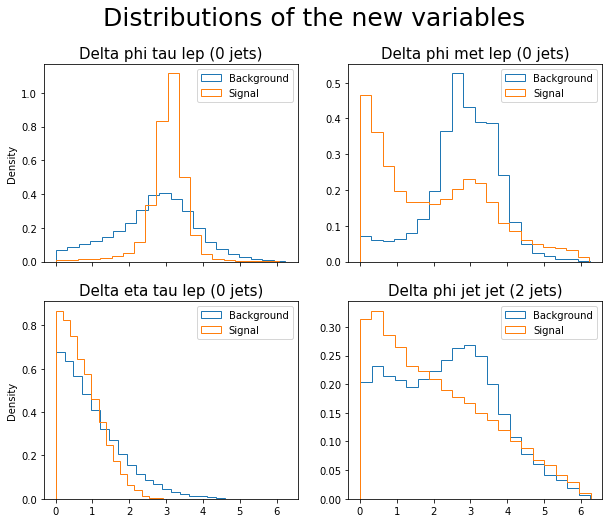

In [17]:
a1 = X_0jets['Delta_phi_tau_lep']
a2 = X_0jets['Delta_phi_met_lep']
a3 = X_0jets['Delta_eta_tau_lep']
a4 = X_2jets['Delta_phi_jet_jet']

fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=True)

ax[0,0].hist(a1[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[0,0].hist(a1[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[0,0].set_title('Delta phi tau lep (0 jets)', fontsize=15)
ax[0,0].set_ylabel('Density')

ax[0,1].hist(a2[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[0,1].hist(a2[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[0,1].set_title('Delta phi met lep (0 jets)', fontsize=15)

ax[1,0].hist(a3[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[1,0].hist(a3[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[1,0].set_title('Delta eta tau lep (0 jets)', fontsize=15)
ax[1,0].set_ylabel('Density')

ax[1,1].hist(a4[y_train_2jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[1,1].hist(a4[y_train_2jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[1,1].set_title('Delta phi jet jet (2 jets)', fontsize=15)

plt.suptitle('Distributions of the new variables', fontsize=25)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()


#plt.savefig('new_variables.png', dpi=300)

del a1, a2, a3, a4

Yes, they're good. The discrimination between signal and background is clear.

## Import some other functions

I used the library "keras" for the construction of my DNN.

In [19]:
from sklearn.preprocessing import StandardScaler #This is the best one (I tried almost all the well known scaler).

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1, l2
from keras.callbacks.callbacks import EarlyStopping

## Define our make_model function

I defined this function in a way to avoid to repeat everytime the same code for a new DNN. Some parameters like the loss function, the accuracy and the regularizer are very similar for each network.  They have been choosen after a long selection of the ones that I thought were the best for my work.

In [21]:
def make_model(layer_sizes, activation, dropout_rate, optimizer, regularization, lambda_reg, input_dimension):
    '''Creates model comprised of dense layers'''
    
    model = Sequential()
    
    if regularization == 'L1':
        regularizer = l1(lambda_reg)
    elif regularization == 'L2':
        regularizer = l2(lambda_reg)
    
    model.add(Dense(units=layer_sizes[0], activation=activation, kernel_regularizer=regularizer , input_dim= input_dimension))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation, kernel_regularizer=regularizer ))
        model.add(Dropout(dropout_rate))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# AMS Score

I define the AMS as the metric for the evaluation of my network:

$AMS = \sqrt{2 \left( (s + b + b_{reg}) ln\left(1 + \dfrac{s}{b + b_{reg}} \right) -s \right)}$

where:
+ $s = \sum_{i} w^{s}_{i}$ that is the unormalized sum of signal weights.
+ $b = \sum_{i} w^{b}_{i}$ that is the unormalized sum of background weights.
+ $b_{reg} = 10$ is a regularization therm that reduces the variance of the AMS.

In [22]:
def NN_output_to_AMS(x_cut, predictions, label_vectors, weights):
    
    b_reg = 10
    
    s = sum(weights[(predictions[:,1] > x_cut)  & (label_vectors[:,1] ==1)])
    b = sum(weights[(predictions[:,1] > x_cut)  & (label_vectors[:,1] ==0)])

    AMS = np.sqrt(      2 *( (s + b + b_reg) * np.log(1 + s/(b + b_reg)) -s )     )
    
    return AMS


def plot_AMS(predictions, label_vectors, weights):
    x = np.arange(0.5,1,1e-2)
    AMS_list=[]
    for x_values in x:
        AMS_list.append(NN_output_to_AMS(x_values, predictions, label_vectors, weights))
    y=np.array(AMS_list)

    plt.plot(x, y)
    plt.xlabel('Cut Parameter')
    plt.ylabel('AMS Score')
    plt.grid()
    
    print('The best AMS Score is {:.3f} at a Cut Parameter of {:.2f}'.format(max(y), x[np.argmax(y)]))

# Plot distributions

This function is useful for the plotting of the histograms of my model.

In [23]:
def plot_distributions(prediction, true, n_bins, weighted, weights):
    
    # Get histograms from our model
    if weighted:
        hist_b = np.histogram(prediction[:,1][true[:,0]==1], bins=n_bins, range=(0,1), weights=weights[true[:,0]==1])
        hist_s = np.histogram(prediction[:,1][true[:,1]==1], bins=n_bins, range=(0,1), weights=50*weights[true[:,1]==1])
        
    else:
        hist_b = np.histogram(prediction[:,1][true[:,0]==1], bins=n_bins, range=(0,1))
        hist_s = np.histogram(prediction[:,1][true[:,1]==1], bins=n_bins, range=(0,1))

    bin_edges = hist_b[1]
    bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2
    bin_widths = (bin_edges[1:] - bin_edges[:-1])

    # Draw objects
    ax = plt.subplot(111)
    ax.bar(bin_centers, hist_b[0], width=bin_widths, alpha=.9)
    ax.bar(bin_centers, hist_s[0], bottom=hist_b[0], width=bin_widths, alpha=.9)
    plt.xlim(-.01,1.01)

    if weighted:
        plt.title("Weighted Validation Set Distribution")
        plt.legend(['Background', r'$50\cdot$Signal'])
    else:
        plt.title("Validation Set Distribution (unweighted)")
        plt.legend(['Background', 'Signal'])
    plt.xlabel("DNN Output")
    plt.ylabel("Counts")
    plt.yscale('log')

## 2-jets Classification

I first started scaling my data.

In [25]:
standard_2jets = StandardScaler()
standard_2jets.fit(X_2jets)
X_2jets_standard = standard_2jets.transform(X_2jets)
X_val_2jets_standard = standard_2jets.transform(X_val_2jets)

Now let's perform a DNN.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 72543 samples, validate on 29046 samples
Epoch 1/50
72543/72543 [==============================] - 2s 34us/step - loss: 0.4970 - accuracy: 0.7802 - val_loss: 0.4109 - val_accuracy: 0.8322
Epoch 2/50
72543/72543 [==============================] - 2s 22us/step - loss: 0.4147 - accuracy: 0.8335 - val_loss: 0.3887 - val_accuracy: 0.8423
Epoch 3/50
72543/72543 [==============================] - 2s 22us/step - loss: 0.3960 - accuracy: 0.8407 - val_loss: 0.3829 - val_accuracy: 0.8431
Epoch 4/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3868 - accuracy: 0.8447 - val_loss: 0.3787 - val_accuracy: 0.8435
Epoch 5/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3792 - accuracy: 0.8472 - val_loss: 0.3725 - val_accuracy: 0.8477
Epoch 6/50
72543/72543 [==============================] - 2s 22us/step - loss: 0.3746 - accuracy: 0.8496 - val_loss: 0.3

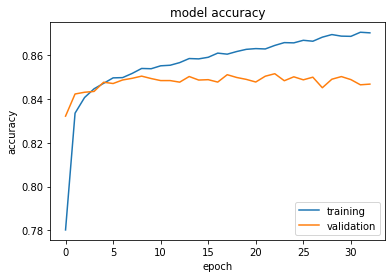

The best AMS Score is 2.353 at a Cut Parameter of 0.97


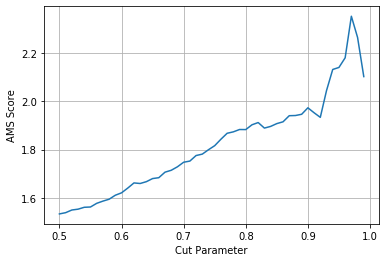

In [26]:
np.random.seed(42)
DNN_2jets = make_model([64, 128, 64, 64, 32, 8], 'relu', 0.1, 'Adam', 'L2', 0.0001, X_2jets.shape[-1])

#This command stops the network when the accuracy stop rising.
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_2jets.fit(X_2jets_standard, y_train_2jets, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_2jets_standard, y_val_2jets), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_2jets = DNN_2jets.predict(X_val_2jets_standard)
plot_AMS(y_pred_2jets, y_val_2jets, weights_2jets)

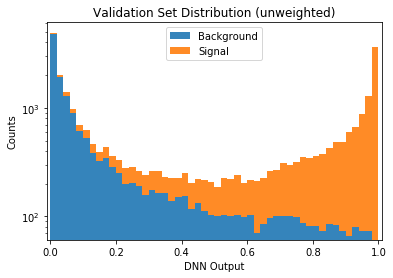

In [27]:
plot_distributions(y_pred_2jets, y_val_2jets, 50, weighted=False, weights = None)

In [28]:
del X_2jets_standard, X_val_2jets_standard, X_2jets, X_val_2jets

## 1 jet:

Now let's do the same with the other subsets.

In [29]:
standard_1jet = StandardScaler()
standard_1jet.fit(X_1jet)
X_1jet_standard = standard_1jet.transform(X_1jet)
X_val_1jet_standard = standard_1jet.transform(X_val_1jet)

In [30]:
X_1jet.shape

(77544, 22)

Train on 77544 samples, validate on 30791 samples
Epoch 1/50
77544/77544 [==============================] - 2s 21us/step - loss: 0.5796 - accuracy: 0.7831 - val_loss: 0.5196 - val_accuracy: 0.8081
Epoch 2/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.5232 - accuracy: 0.8081 - val_loss: 0.5018 - val_accuracy: 0.8120
Epoch 3/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.5094 - accuracy: 0.8116 - val_loss: 0.4927 - val_accuracy: 0.8155
Epoch 4/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4994 - accuracy: 0.8141 - val_loss: 0.4872 - val_accuracy: 0.8138
Epoch 5/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4933 - accuracy: 0.8152 - val_loss: 0.4824 - val_accuracy: 0.8147
Epoch 6/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4885 - accuracy: 0.8158 - val_loss: 0.4772 - val_accuracy: 0.8169
Epoch 7/50
77544/77544 [==============================] - 1s 18us/st

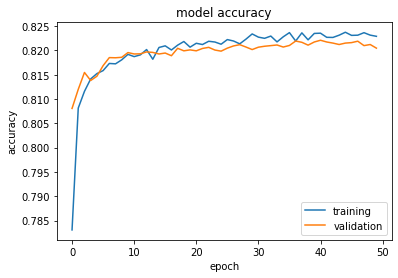

The best AMS Score is 1.652 at a Cut Parameter of 0.72


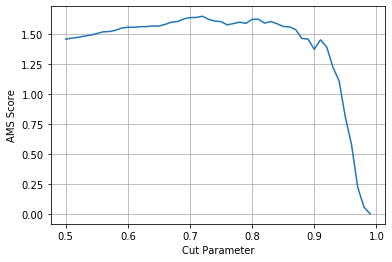

In [31]:
np.random.seed(42)
DNN_1jet = make_model([64, 64, 64, 32, 8], 'relu', 0.1, 'Adagrad', 'L1', 0.0001, X_1jet.shape[-1])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_1jet.fit(X_1jet_standard, y_train_1jet, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_1jet_standard, y_val_1jet), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_1jet = DNN_1jet.predict(X_val_1jet_standard)
plot_AMS(y_pred_1jet, y_val_1jet, weights_1jet)

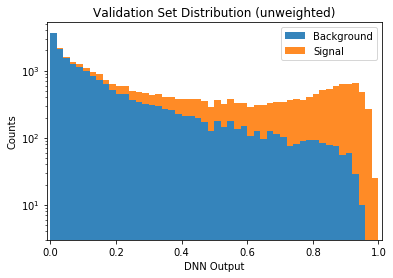

In [32]:
plot_distributions(y_pred_1jet, y_val_1jet, 50, weighted=False, weights = None)

In [33]:
del X_1jet_standard, X_val_1jet_standard, X_1jet, X_val_1jet

### 0 jets

In [34]:
standard_0jets = StandardScaler()
standard_0jets.fit(X_0jets)
X_0jets_standard = standard_0jets.transform(X_0jets)
X_val_0jets_standard = standard_0jets.transform(X_val_0jets)

Train on 99913 samples, validate on 40163 samples
Epoch 1/50
99913/99913 [==============================] - 3s 26us/step - loss: 0.5502 - accuracy: 0.8361 - val_loss: 0.5099 - val_accuracy: 0.8446
Epoch 2/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.5011 - accuracy: 0.8429 - val_loss: 0.4820 - val_accuracy: 0.8451
Epoch 3/50
99913/99913 [==============================] - 2s 25us/step - loss: 0.4768 - accuracy: 0.8440 - val_loss: 0.4624 - val_accuracy: 0.8463
Epoch 4/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4597 - accuracy: 0.8454 - val_loss: 0.4503 - val_accuracy: 0.8450
Epoch 5/50
99913/99913 [==============================] - 2s 25us/step - loss: 0.4473 - accuracy: 0.8451 - val_loss: 0.4391 - val_accuracy: 0.8460
Epoch 6/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4373 - accuracy: 0.8458 - val_loss: 0.4321 - val_accuracy: 0.8446
Epoch 7/50
99913/99913 [==============================] - 2s 25us/st

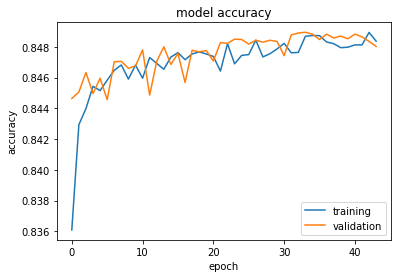

The best AMS Score is 2.482 at a Cut Parameter of 0.78


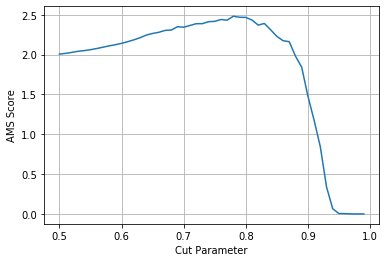

In [35]:
np.random.seed(42)
DNN_0jets = make_model([32, 64, 128, 64, 32, 8], 'elu', 0.1, 'Adagrad', 'L1', 0.0001, X_0jets.shape[-1])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_0jets.fit(X_0jets_standard, y_train_0jets, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_0jets_standard, y_val_0jets), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_0jets = DNN_0jets.predict(X_val_0jets_standard)
plot_AMS(y_pred_0jets, y_val_0jets, weights_0jets)

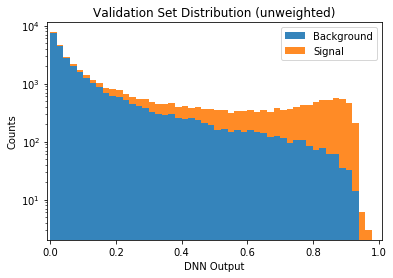

In [36]:
plot_distributions(y_pred_0jets, y_val_0jets, 50, weighted=False, weights = None)

In [37]:
del X_0jets_standard, X_val_0jets_standard, X_0jets, X_val_0jets

# Total AMS Score from our DNNs:

Total AMS score considering all the AMS of each subset:

In [40]:
y_pred_total = np.concatenate((y_pred_0jets, y_pred_1jet, y_pred_2jets))
y_val_total = np.concatenate((y_val_0jets, y_val_1jet, y_val_2jets))
weights_total = np.concatenate((weights_0jets, weights_1jet, weights_2jets))

The best AMS Score is 3.485 at a Cut Parameter of 0.80


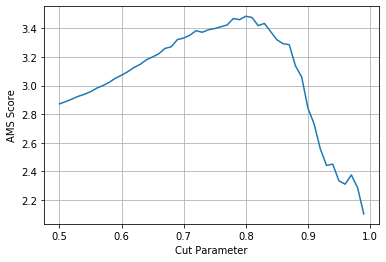

In [41]:
plot_AMS(y_pred_total, y_val_total, weights_total)
#plt.savefig('AMS_Score.png', dpi=250)

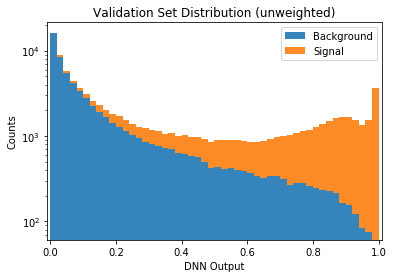

In [42]:
plot_distributions(y_pred_total, y_val_total, 50, weighted=False, weights=None)
plt.savefig('Distributions.png', dpi=250)

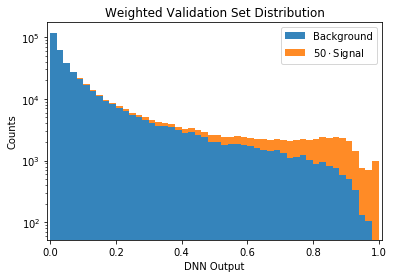

In [43]:
plot_distributions(y_pred_total, y_val_total, 50, weighted=True, weights=weights_total)
plt.savefig('Distributions_weighted.png', dpi=250)